In [4]:
import numpy as np
from ptsa.data.readers import EEGReader,TalReader
from ptsa.data.filters import MorletWaveletFilterCpp,MonopolarToBipolarMapper, MorletWaveletFilter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from ptsa.data.TimeSeriesX import TimeSeriesX
import pandas as pd
from scipy.stats import zscore,ttest_rel
%matplotlib inline 
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve
from cluster_helper import cluster
from sklearn.externals import joblib
import xarray


Could not import MorletWaveletFilterCppLegacy (single-core C++ version of MorletWaveletFilter): cannot import name 'MorletWaveletTransform'
You can still use MorletWaveletFilter


In [5]:
def lolo(numS, numL,features):
    #regular = sessions w/out left out list
    regular = features.sel(events=features.events.values['session'] != numS)
    for session in np.unique(regular.events.values['session']):
            regular[regular.events.values['session']==session] = zscore(
                        regular[regular.events.values['session']==session],
                                                                     axis=0)
    regularZ = regular
    
    #session containing left out list, minus the left out list itself
    left_out = features.sel(events=features.events.values['session']==numS)
    left_out = left_out.sel(events=left_out.events.values['list']!= numL)
    left_outZ = (left_out - left_out.mean('events'))/left_out.std('events')
    
    #the test list itself (the lolo)
    test_list = features.sel(events = features.events.values['list'] == numL)
    test_list = test_list.sel(events=test_list.events.values['session']==numS)
    test_listZ = (test_list - left_out.mean('events'))/left_out.std('events')
    
    #training is new TimeSeriesX with everything except left out list
    training = xarray.concat([regularZ,left_outZ], 'events')
    temp = np.r_[regularZ.events.values, left_outZ.events.values]
    training.events.values = temp.view(np.recarray)
    
    #logistic regression
    lr = LogisticRegression(penalty='l2', C=1.0)
    lrFit = lr.fit(training, training.events.values['recalled'])
    test_probs = lrFit.predict_proba(test_listZ)[:, 1]
    actual_labels = test_listZ.events.values['recalled']
    return [test_probs, actual_labels]

In [6]:
#leave one list out = lolo (lol)
def get_probs_actual_lolo(feat_array):
    lolo_labels = []
    for s, l in zip((feat_array.events.values['session']), (feat_array.events.values['list'])):
        lolo_labels.append(str(s)+'-'+str(l))

    probs = np.empty(len(feat_array))
    probs.fill(np.nan)
    actual = np.empty(len(feat_array))
    actual.fill(np.nan)

    count = 0
    for label in np.unique(lolo_labels):
        count = count+1
        print(str(count) + '/' + str(len(np.unique(lolo_labels))))
        lab = label.split('-')
        trial = int(lab[1])
        ss = int(lab[0])
        lolo_result = lolo(ss,trial,feat_array)
        probs[(feat_array.events.values['session']==ss)&(feat_array.events.values['list']==trial)] = lolo_result[0]
        actual[(feat_array.events.values['session']==ss)&(feat_array.events.values['list']==trial)] = lolo_result[1]
    return [probs,actual]


In [7]:
def get_loso(regular, vault):
    for session in np.unique(regular.events.values['session']):
            regular[regular.events.values['session']==session] = zscore(
                        regular[regular.events.values['session']==session],
                                                                     axis=0)
    remainingZ = regular
    vaultZ = (vault - vault.mean('events'))/vault.std('events')
    #logistic regression
    lr = LogisticRegression(penalty='l2', C=1.0)
    lrFit = lr.fit(remainingZ, remainingZ.events.values['recalled'])
    vault_predictions = lrFit.predict_proba(vaultZ)[:, 1]
    vault_actuals = vaultZ.events.values['recalled']
    return [vault_predictions, vault_actuals]

In [8]:
#ROC curve depicts True Positive Rate (on the y-axis) versus the False Positive Rate (on the x-axis)
#classifer_ps: array of classifier output probabilities
#values: array of values that correspond to their true labels
#labels: array of true labels for the above values
#posLabel: label for the positive class
#returns ROC curve [xs, ys]
def getROC(classifier_ps, labels, values, posLabel):
    xs = [0] * len(classifier_ps)
    ys = xs[:]
    
    #use each probability as a decision threshold (< is neg, >= is pos)
    numPos = sum((labels[i] == posLabel) for i in range(0, len(values)))
    numNeg = sum((labels[i] != posLabel) for i in range(0, len(values)))
    count = 0
    for threshold in classifier_ps:
        falsePosCount = sum((values[i] >= threshold and labels[i] != posLabel) for i in range(0, len(values)))
        truePosCount = sum((values[i] >= threshold and labels[i] == posLabel) for i in range(0, len(values)))

        fpr = (1.0 * falsePosCount) / numNeg
        tpr = (1.0 * truePosCount) / numPos
        xs[count] = fpr
        ys[count] = tpr
        count += 1
    
    return [np.array(xs), np.array(ys)]
        

def getAUC(rocX, rocY):
    return np.trapz(rocY, rocX)

def plotROCAvg(title, base_fpr, tprs_lolo, tprs_loso, filename=None): 
    avg_tprs_lolo = np.mean(tprs_lolo, axis=0)
    ste_tprs_lolo = np.std(tprs_lolo,axis=0) / np.sqrt(np.shape(tprs_lolo)[0])
    lolo_lower = avg_tprs_lolo - ste_tprs_lolo
    lolo_upper = np.minimum(avg_tprs_lolo + ste_tprs_lolo,1)
    
    
    avg_tprs_loso = np.mean(tprs_loso, axis=0)
    ste_tprs_loso = np.std(tprs_loso,axis=0) / np.sqrt(np.shape(tprs_loso)[0])
    loso_lower = avg_tprs_loso - ste_tprs_loso
    loso_upper = np.minimum(avg_tprs_loso + ste_tprs_loso,1)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    plt.title(title)
    
    all_tprs = {'LOLO': {'tpr': avg_tprs_lolo, 'color': 'blue'}, 'LOSO': {'tpr': avg_tprs_loso, 'color': 'orange'}}
    for label in ['LOLO', 'LOSO']:
        ax.plot(base_fpr, all_tprs[label]['tpr'], 
                label='%s; AUC=%.3f' % (label, getAUC(base_fpr, all_tprs[label]['tpr'])),
               color=all_tprs[label]['color'])
    
    
    plt.fill_between(base_fpr, lolo_lower, lolo_upper, color= all_tprs['LOLO']['color'], alpha = 0.3)
    
    plt.fill_between(base_fpr, loso_lower, loso_upper, color= all_tprs['LOSO']['color'], alpha = 0.3)

    
    ax.legend(loc='best')
    ax.plot([0,1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    if filename:
        plt.savefig("%s.jpg" % (filename), bbox_inches='tight')

    plt.show()
    

def plotROC(title, labelParam, labels, ROCXs, ROCYs, filename=None):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    plt.title(title)
    i = 0
    for label in labels:
        ax.plot(ROCXs[i], ROCYs[i], label='%s%s%s; AUC=%.3f' % (labelParam if labelParam else '', 
                                                                '=' if labelParam else '' ,
                                                                labels[i], getAUC(ROCXs[i], ROCYs[i])))
        i+=1
    ax.legend(loc='best', title=labelParam)
    ax.plot([0,1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #fig.subplots_adjust(0.18,0.16, 0.98, 0.99, 0.1, 0.1)

    if filename:
        plt.savefig("%s.jpg" % (filename), bbox_inches='tight')

    plt.show()

R1051J
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
R1060M
1/75
2/75
3/75
4/75
5/75
6/75
7/75
8/75
9/75
10/75
11/75
12/75
13/75
14/75
15/75
16/75
17/75
18/75
19/75
20/75
21/75
22/75
23/75
24/75
25/75
26/75
27/75
28/75
29/75
30/75
31/75
32/75
33/75
34/75
35/75
36/75
37/75
38/75
39/75
40/75
41/75
42/75
43/75
44/75
45/75
46/75
47/75
48/75
49/75
50/75
51/75
52/75
53/75
54/75
55/75
56/75
57/75
58/75
59/75
60/75
61/75
62/75
63/75
64/75
65/75
66/75
67/75
68/75
69/75
70/75
71/75
72/75
73/75
74/75
75/75
R1065J
1/125
2/125
3/125
4/125
5/125
6/125
7/125
8/125
9/125
10/125
11/125
12/125
13/125
14/125
15/125
16/125
17/125
18/125
19/125
20/125
21/125
22/125
23/125
24/125
25/125
26/125
27/125
28/125
29/125
30/125
31/125
32/125
33/125
34/125
35/125
36/125
37/1

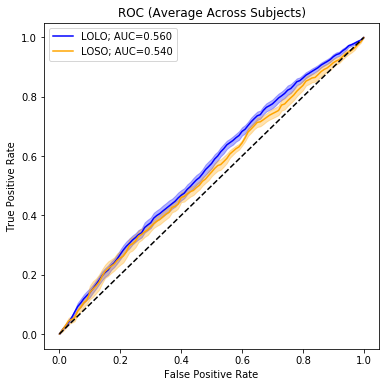

{'R1051J': '0.559', 'R1060M': '0.534', 'R1065J': '0.596', 'R1137E': '0.610', 'R1154D': '0.604', 'R1161E': '0.514', 'R1189M': '0.542', 'R1195E': '0.556', 'R1236J': '0.524'}
{'R1051J': '0.531', 'R1060M': '0.589', 'R1065J': '0.550', 'R1137E': '0.493', 'R1154D': '0.520', 'R1161E': '0.507', 'R1189M': '0.540', 'R1195E': '0.514', 'R1236J': '0.611'}


In [9]:
from scipy import interp

subs=  ['R1051J', 'R1060M', 'R1065J', 'R1137E', 'R1154D', 'R1161E','R1189M', 'R1195E', 'R1236J']

tprs_lolo = []
tprs_loso = []
base_fpr = np.linspace(0, 1, 101)

aucs_lolo = {}
aucs_loso = {}


for subjectID in subs:
    print(subjectID)
    data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/iEEG_Power_Files/%s.hdf5' % (subjectID))
# #     if (subjectID=='R1061T'):
# #         bad_event = 972
# #         data = np.delete(data,np.s_[bad_event], axis=2)
    
    features = np.log10(data.stack(features=('frequency','bipolar_pairs')))
    
    lastSession = np.max(np.unique(features.events.values['session']))
    vault = features.sel(events=features.events.values['session']==lastSession)
    remaining = features.sel(events=features.events.values['session']!=lastSession)
    
    data_remaining = get_probs_actual_lolo(remaining)
#     data_remaining, data_vault = np.load('/data/home/jonlevi/ML_Project/iEEG_data_files/%s.npy' % (subjectID))
    
    probs_remaining = data_remaining[0]
    actual_remaining = data_remaining[1]
    
    data_vault = get_loso(remaining,vault)
    probs_vault = data_vault[0]
    actual_vault = data_vault[1]

#     incr = 0.001
#     thresholds = np.arange(1 + incr, -1 * incr, -1 * incr)
    _,_,thresholds = roc_curve(actual_remaining, probs_remaining)
    myROC_LOLO = getROC(thresholds,actual_remaining,probs_remaining,1)
    fprs = myROC_LOLO[0]
    tprs = myROC_LOLO[1]
    aucs_lolo[subjectID] = format(getAUC(fprs,tprs),'.3f')
    tpr_lolo = interp(base_fpr, fprs, tprs)
    tpr_lolo[0] = 0.0
    tprs_lolo.append(tpr_lolo)
    

    _,_,thresholds = roc_curve(actual_vault, probs_vault)
    myROC_LOSO = getROC(thresholds,actual_vault,probs_vault,1)
    fprs2 = myROC_LOSO[0]
    tprs2 = myROC_LOSO[1]
    aucs_loso[subjectID] = format(getAUC(fprs2,tprs2),'.3f')
    tpr_loso = interp(base_fpr, fprs2, tprs2)
    tpr_loso[0] = 0.0
    tprs_loso.append(tpr_loso)

plotROCAvg("ROC (Average Across Subjects)",base_fpr, tprs_lolo, tprs_loso,
       '/data/home/jonlevi/ML_Project/figs/average_rocs2')

print(aucs_lolo)
print(aucs_loso)

In [16]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(aucs_lolo)
pp.pprint(aucs_loso)

{   'R1051J': '0.559',
    'R1060M': '0.542',
    'R1065J': '0.590',
    'R1137E': '0.610',
    'R1154D': '0.604',
    'R1161E': '0.514',
    'R1189M': '0.542',
    'R1195E': '0.556',
    'R1236J': '0.528'}
{   'R1051J': '0.531',
    'R1060M': '0.586',
    'R1065J': '0.542',
    'R1137E': '0.496',
    'R1154D': '0.511',
    'R1161E': '0.507',
    'R1189M': '0.547',
    'R1195E': '0.511',
    'R1236J': '0.594'}


In [124]:
# newData = data[:,:,range(0, bad_event) + range(bad_event, )]
#training is new TimeSeriesX with everything except left out list
newData = np.delete(data,np.s_[bad_event], axis=2)
#     temp = np.r_[regularZ.events.values, left_outZ.events.values]
#     training.events.values = temp.view(np.recarray)

newData.events.values[:,:,bad_event]

IndexError: too many indices for array

In [105]:
bad_event = 972
data[:][:][bad_event] = [.01] * len(data[0][0])
# for freq in range(0,7):
#     for bipair in range(0,108):
#         subdata = data[freq][bipair]
#         if np.any(subdata == 0):
#             #print('FUCK %s-%s' % (freq, bipair))
#             print('event at %s' % list(subdata.values).index(0))

IndexError: index 972 is out of bounds for axis 0 with size 7

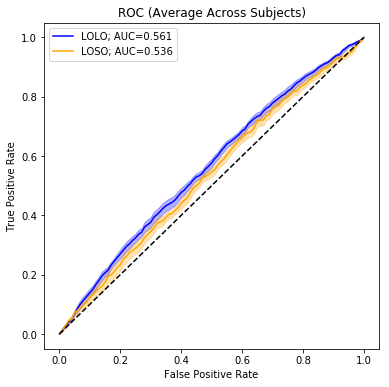

In [128]:
# np.array(tprs_lolo)
# np.mean(tprs_lolo, axis=0)
# #     avg_tprs_lolo = np.mean(tprs_lolo, axis=0)
# #     ste_tprs_lolo = np.std(tprs_lolo,axis=0) / np.sqrt(np.shape(tprs_lolo)[0])
# #     lolo_lower = avg_tprs_lolo - ste_tprs_lolo
# #     lolo_upper = np.minimum(avg_tprs_lolo + ste_tprs_lolo,1)





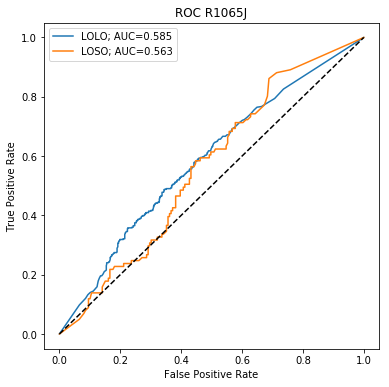

In [92]:
plotROC("ROC %s" % subjectID, None , ['LOLO', 'LOSO'], [fprs, fprs2], [tprs, tprs2], '/data/home/jonlevi/ML_Project/figs/%s' % subjectID)

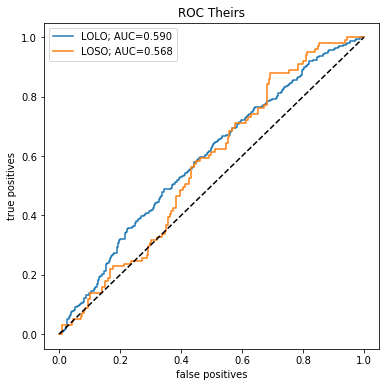

In [73]:
# fprs, tprs ,thresholds = roc_curve(actual,probs)

# fprs2, tprs2 ,thresholds = roc_curve(vault_actuals,vault_predictions)

# plotROC("ROC Theirs", None , ['LOLO', 'LOSO'], [fprs, fprs2], [tprs, tprs2])